This notebook tries to search for optimal fixed policies (e.g. constant mortality) that maximize the objective (i.e. expected net reward). Here I try [scikit-optimize](https://scikit-optimize.github.io/stable/index.html).

# Setup
---

In [1]:
# %pip install -e ..
# %pip install scikit-optimize

In [1]:
import numpy as np
import pandas as pd
import ray

from skopt import gp_minimize, gbrt_minimize 
from skopt import dump
from skopt.plots import plot_objective, plot_convergence
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.envs.asm_fns import get_r_devs

In [11]:
CONFIG = {"s":  0.86, "p_big": 0.1}

In [15]:
env = AsmEnv(config=CONFIG)
env.parameters['bhb'], env.parameters['bha']

(2.2530262102712397, 2.703631452325488)

In [ ]:
%%time
esc_gp = gp_minimize(esc_obj, esc_space, n_calls = 50, verbose=True, n_jobs=-1)
esc_gp.fun, esc_gp.x

## Hugging face login

In [3]:
## download & upload saved model weights
from huggingface_hub import hf_hub_download, HfApi, login
api = HfApi()
login()

# Policy Optimization
---

## Policy evaluation fn

In [4]:
@ray.remote
def generate_rew(policy, env_cls, config):
    ep_rew = 0
    env = env_cls(config=config)
    obs, info = env.reset()
    for t in range(env.Tmax):
        act, info = policy.predict(obs)
        obs, rew, term, trunc, info = env.step(act)
        ep_rew += rew
    return ep_rew


def rew_batch(policy, env_cls, config, batch_size):
    tmax = env_cls().Tmax
    parallel = [generate_rew.remote(policy, env_cls, config) for _ in range(batch_size)]
    rews = ray.get(parallel)
    
    return rews

def eval_pol(policy, env_cls, config, n_batches=4, batch_size=40, pb=False):
    batch_iter = range(n_batches)
    if pb:
        from tqdm import tqdm
        batch_iter = tqdm(iter)
    #
    rews = []
    for i in batch_iter:
        rews.append(
            rew_batch(policy=policy, env_cls=env_cls, config=config, batch_size=batch_size)
        )
    return np.array(rews).flatten()

## Objective fns

In [5]:
msy_space = [Real(0.001, 0.25, name='mortality')]
esc_space = [Real(0.001, 0.80, name='escapement')]
cr_space  = [
    Real(0.00001, 1, name='radius'),
    Real(0.00001, np.pi/4.00001, name='theta'),
    Real(0, 1, name='y2'),
]

@use_named_args(msy_space)
def msy_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    agent = Msy(env=eval_env, mortality = x['mortality'])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=4, batch_size=40
    )
    return -np.mean(rews)

@use_named_args(esc_space)
def esc_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    agent = ConstEsc(env=eval_env, escapement = x['escapement'])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=4, batch_size=40
    )
    return -np.mean(rews)

@use_named_args(cr_space)
def cr_obj(**x):
    theta = x["theta"]
    radius = x["radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    #
    eval_env = AsmEnv(config=CONFIG)
    eval_env.reset()
    agent = CautionaryRule(env=eval_env, x1 = x1, x2 =  x2, y2 = x["y2"])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, 
        config=CONFIG, 
        n_batches=4, batch_size=40
    )
    return -np.mean(rews)  



## Optimization

### MSY

In [85]:
%%time
msy_gp = gp_minimize(msy_obj, msy_space, n_calls = 50, verbose=True, n_jobs=-1)
msy_gp.fun, msy_gp.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.9026
Function value obtained: -10.5153
Current minimum: -10.5153
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8077
Function value obtained: -420.3512
Current minimum: -420.3512
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.7918
Function value obtained: -16.8727
Current minimum: -420.3512
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8600
Function value obtained: -419.8449
Current minimum: -420.3512
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.9068
Function value obtained: -22.9095
Current minimum: -420.3512
Iteration

(-435.2489318270209, [0.06034835458305745])

<Axes: >

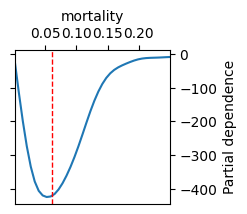

In [86]:
plot_objective(msy_gp)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

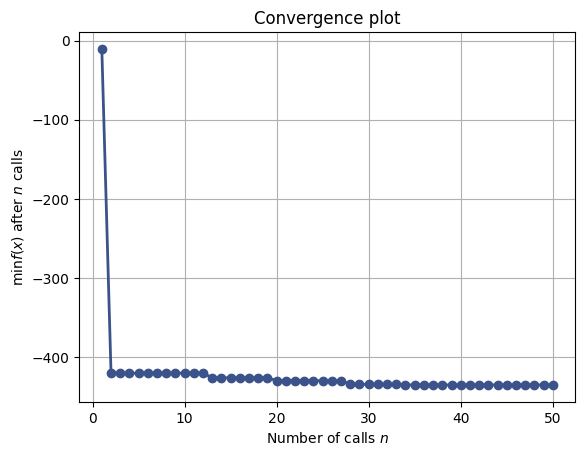

In [87]:
plot_convergence(msy_gp)

In [88]:
%%time
msy_gbrt = gbrt_minimize(msy_obj, msy_space, n_calls = 50, verbose=True, n_jobs=-1)
msy_gbrt.fun, msy_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8035
Function value obtained: -221.2843
Current minimum: -221.2843
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8925
Function value obtained: -10.2133
Current minimum: -221.2843
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.8206
Function value obtained: -415.1535
Current minimum: -415.1535
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.7985
Function value obtained: -8.6206
Current minimum: -415.1535
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.7964
Function value obtained: -8.1362
Current minimum: -415.1535
Iteration 

(-435.07193758413604, [0.0473505166744664])

<Axes: >

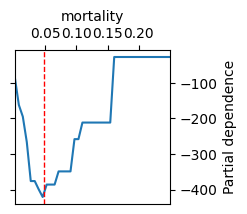

In [89]:
plot_objective(msy_gbrt)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

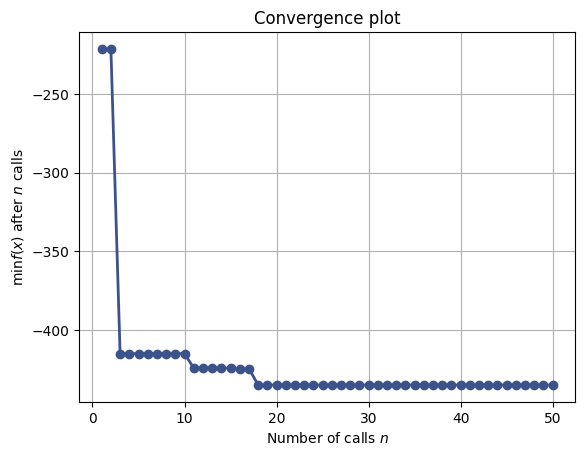

In [90]:
plot_convergence(msy_gbrt)

### Esc

In [12]:
%%time
esc_gp = gp_minimize(esc_obj, esc_space, n_calls = 50, verbose=True, n_jobs=-1)
esc_gp.fun, esc_gp.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.9448
Function value obtained: -61.2205
Current minimum: -61.2205
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7981
Function value obtained: -1.3165
Current minimum: -61.2205
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.7924
Function value obtained: -0.0000
Current minimum: -61.2205
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8847
Function value obtained: -0.0043
Current minimum: -61.2205
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.8267
Function value obtained: -116.8023
Current minimum: -116.8023
Iteration No: 6 

/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.38927630582277944]
  warnings.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 2.3965
Function value obtained: -0.0000
Current minimum: -276.4398
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 2.3848
Function value obtained: -0.0000
Current minimum: -276.4398
Iteration No: 15 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.18417481589713974]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 2.3431
Function value obtained: -9.8336
Current minimum: -276.4398
Iteration No: 16 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.6163259384209202]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 2.3639
Function value obtained: -0.0000
Current minimum: -276.4398
Iteration No: 17 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.7620265074972382]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.4569
Function value obtained: -0.0000
Current minimum: -276.4398
Iteration No: 18 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.7176335045210767]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.9941
Function value obtained: -0.0000
Current minimum: -276.4398
Iteration No: 19 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.47975524824311866]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.1352
Function value obtained: -0.0000
Current minimum: -276.4398
Iteration No: 20 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.6610471994826488]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1.1225
Function value obtained: -0.0000
Current minimum: -276.4398
Iteration No: 21 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.5849803799180963]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.2836
Function value obtained: -0.0000
Current minimum: -276.4398
Iteration No: 22 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.39568235674564767]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1.1409
Function value obtained: -0.0000
Current minimum: -276.4398
Iteration No: 23 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.5068234394773203]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.1433
Function value obtained: -0.0000
Current minimum: -276.4398
Iteration No: 24 started. Searching for the next optimal point.


/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001] before, using random point [0.5599477470534967]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.1053
Function value obtained: -0.0000
Current minimum: -276.4398
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.1822
Function value obtained: -119.5722
Current minimum: -276.4398
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.1073
Function value obtained: -124.9303
Current minimum: -276.4398
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.2083
Function value obtained: -129.5423
Current minimum: -276.4398
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.1394
Function value obtained: -133.6385
Current minimum: -276.4398
I

KeyboardInterrupt: 

<Axes: >

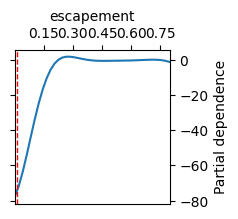

In [6]:
plot_objective(esc_gp)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

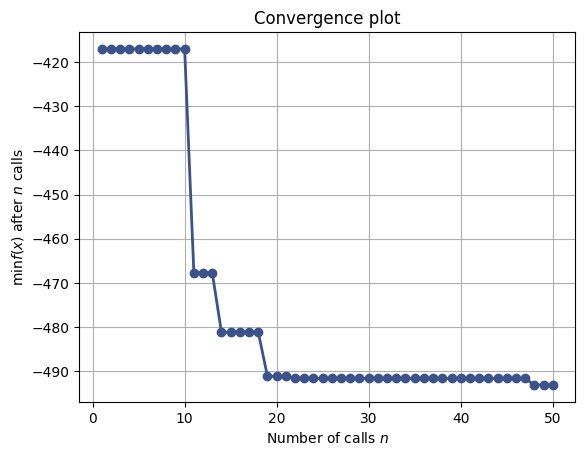

In [93]:
plot_convergence(esc_gp)

In [94]:
%%time
esc_gbrt = gbrt_minimize(esc_obj, esc_space, n_calls = 50, verbose=True, n_jobs=-1)
esc_gbrt.fun, esc_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7164
Function value obtained: -26.8844
Current minimum: -26.8844
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7265
Function value obtained: -222.6033
Current minimum: -222.6033
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.7946
Function value obtained: -80.9190
Current minimum: -222.6033
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.7275
Function value obtained: -22.7700
Current minimum: -222.6033
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.7880
Function value obtained: -15.2744
Current minimum: -222.6033
Iteration 

(-498.2012416556625, [0.09553591362425362])

<Axes: >

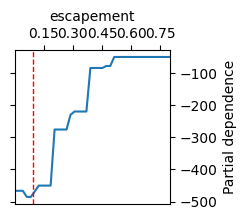

In [95]:
plot_objective(esc_gbrt)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

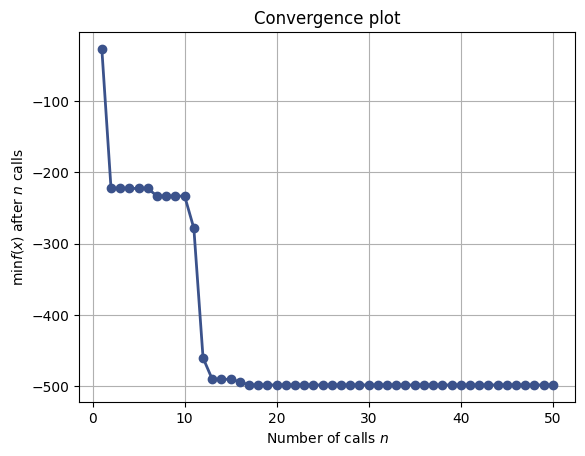

In [96]:
plot_convergence(esc_gbrt)

### CR

In [97]:
%%time
cr_gp = gp_minimize(cr_obj, cr_space, n_calls = 100, verbose=True, n_jobs=-1)
cr_gp.fun, cr_gp.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8137
Function value obtained: -112.5777
Current minimum: -112.5777
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7754
Function value obtained: -494.5841
Current minimum: -494.5841
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.7743
Function value obtained: -105.5923
Current minimum: -494.5841
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8433
Function value obtained: -490.8444
Current minimum: -494.5841
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.8100
Function value obtained: -26.2553
Current minimum: -494.5841
Iterat

(-513.3997923114888,
 [0.3467172508239331, 0.12349136947209918, 0.4543957127238083])

<Axes: >

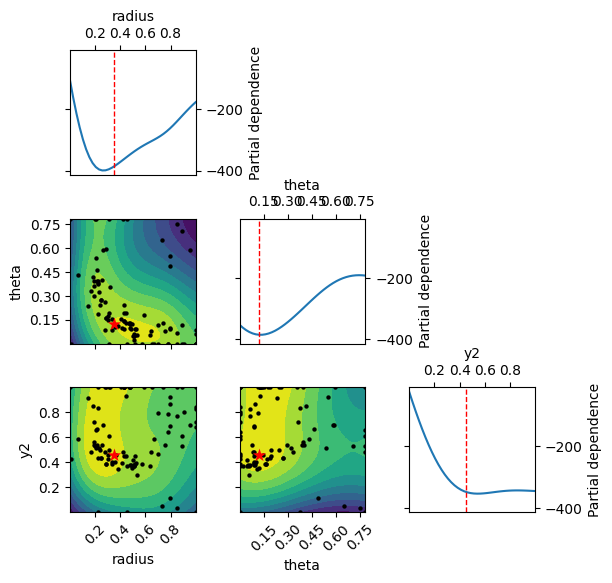

In [98]:
plot_objective(cr_gp)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

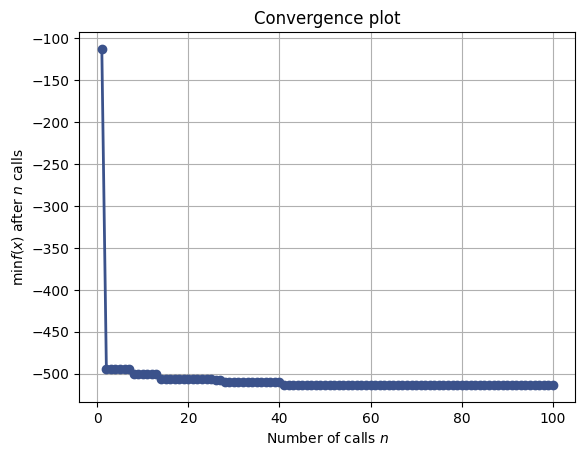

In [99]:
plot_convergence(cr_gp)

In [100]:
%%time
cr_gbrt = gp_minimize(cr_obj, cr_space, n_calls = 100, verbose=True, n_jobs=-1)
cr_gbrt.fun, cr_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8759
Function value obtained: -233.1128
Current minimum: -233.1128
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8044
Function value obtained: -307.0875
Current minimum: -307.0875
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.7951
Function value obtained: -412.8523
Current minimum: -412.8523
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8084
Function value obtained: -338.3821
Current minimum: -412.8523
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.8783
Function value obtained: -424.7119
Current minimum: -424.7119
Itera

(-516.4464921212091,
 [0.4235963298591771, 0.10683989693940918, 0.5989144263953697])

<Axes: >

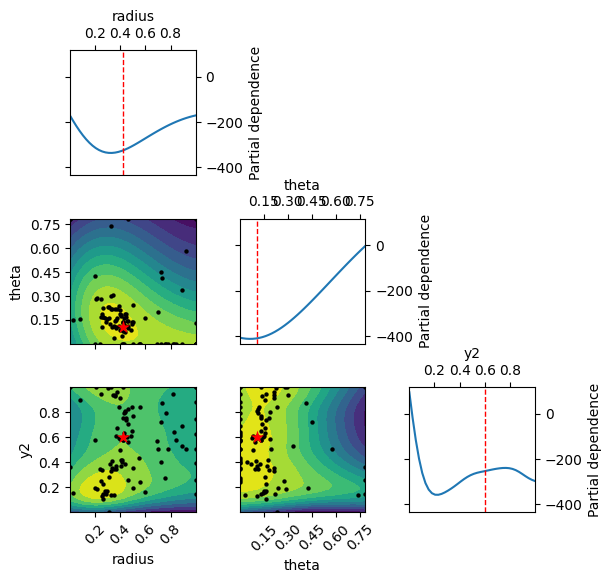

In [101]:
plot_objective(cr_gbrt)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

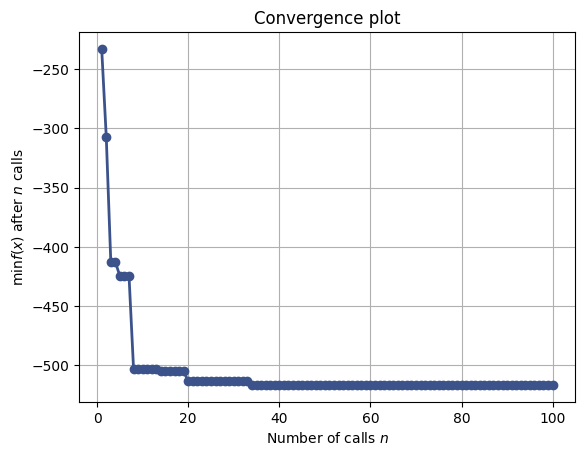

In [102]:
plot_convergence(cr_gbrt)

# Plot policies

In [103]:
def get_policy_df(policy_obj, minx=-1, maxx=1, nx=100):
    obs_list = np.linspace(minx, maxx, nx)
    return pd.DataFrame(
        {
            'obs': obs_list,
            'pop': (obs_list + 1)/2,
            'pol': [policy_obj.predict(np.float32([obs]))[0][0] for obs in obs_list]
        }
    )

In [104]:
cr_gp_preargs = {'radius': cr_gp.x[0], 'theta': cr_gp.x[1], 'y2': cr_gp.x[2]}
cr_gp_args = {}
cr_gp_args['x1'] = cr_gp_preargs['radius'] * np.sin(cr_gp_preargs['theta'])
cr_gp_args['x2'] = cr_gp_preargs['radius'] * np.cos(cr_gp_preargs['theta'])
cr_gp_args['y2'] = cr_gp_preargs['y2']

cr_gbrt_preargs = {'radius': cr_gbrt.x[0], 'theta': cr_gbrt.x[1], 'y2': cr_gbrt.x[2]}
cr_gbrt_args = {}
cr_gbrt_args['x1'] = cr_gbrt_preargs['radius'] * np.sin(cr_gbrt_preargs['theta'])
cr_gbrt_args['x2'] = cr_gbrt_preargs['radius'] * np.cos(cr_gbrt_preargs['theta'])
cr_gbrt_args['y2'] = cr_gbrt_preargs['y2']

msy_gp_args = {'mortality': msy_gp.x[0]}
msy_gbrt_args = {'mortality': msy_gbrt.x[0]}

esc_gp_args = {'escapement': esc_gp.x[0]}
esc_gbrt_args = {'escapement': esc_gbrt.x[0]}

#

env = AsmEnv(config=CONFIG)

cr_gbrt_df = get_policy_df(CautionaryRule(env, **cr_gbrt_args))
cr_gp_df = get_policy_df(CautionaryRule(env, **cr_gp_args))

esc_gbrt_df = get_policy_df(ConstEsc(env, **esc_gbrt_args))
esc_gp_df = get_policy_df(ConstEsc(env, **esc_gp_args))

msy_gbrt_df = get_policy_df(Msy(env, **msy_gbrt_args))
msy_gp_df = get_policy_df(Msy(env, **msy_gp_args))

(<Axes: title={'center': 'Cautionary Rule GP policy'}, xlabel='pop'>,
 <Axes: title={'center': 'Const. Escapement GP policy'}, xlabel='pop'>)

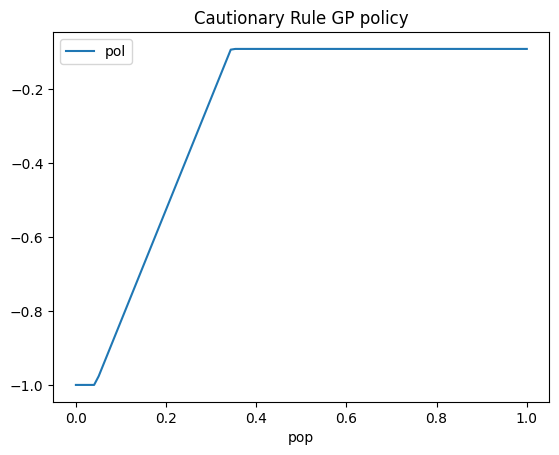

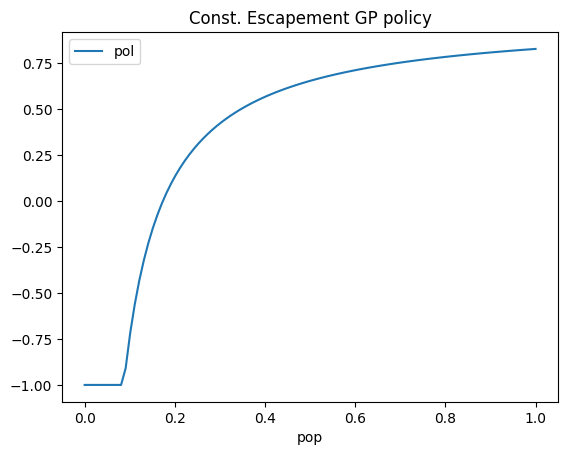

In [107]:
(
    cr_gp_df.plot(x='pop', y='pol', title='Cautionary Rule GP policy'),
    esc_gp_df.plot(x='pop', y='pol', title='Const. Escapement GP policy'),
    # msy_gbrt_df.plot(x='pop', y='pol', title='MSY GP policy'),
)  

# Saving results

### MSY

In [51]:
path = "../saved_agents/"
fname = "msy_gp.pkl"
dump(msy_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

path = "../saved_agents/"
fname = "msy_gbrt.pkl"
dump(msy_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/93a77a99bc7c9d63f939b187be8953839673c1f4', commit_message='Upload sb3/rl4fisheries/msy_gbrt.pkl with huggingface_hub', commit_description='', oid='93a77a99bc7c9d63f939b187be8953839673c1f4', pr_url=None, pr_revision=None, pr_num=None)

### Esc

In [52]:
path = "../saved_agents/"
fname = "esc_gp.pkl"
dump(esc_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

path = "../saved_agents/"
fname = "esc_gbrt.pkl"
dump(msy_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/6d5916a6c8a127c0fad05c60939599a5433977f3', commit_message='Upload sb3/rl4fisheries/esc_gbrt.pkl with huggingface_hub', commit_description='', oid='6d5916a6c8a127c0fad05c60939599a5433977f3', pr_url=None, pr_revision=None, pr_num=None)

### CR

In [53]:
path = "../saved_agents/"
fname = "cr_gp.pkl"
dump(cr_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

path = "../saved_agents/"
fname = "cr_gbrt.pkl"
dump(cr_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

cr_gp.pkl:   0%|          | 0.00/5.96M [00:00<?, ?B/s]

cr_gbrt.pkl:   0%|          | 0.00/5.96M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/27377b295b025a82b77e1010c4ec40e0530a7ac5', commit_message='Upload sb3/rl4fisheries/cr_gbrt.pkl with huggingface_hub', commit_description='', oid='27377b295b025a82b77e1010c4ec40e0530a7ac5', pr_url=None, pr_revision=None, pr_num=None)

# Cross evaluate

In [28]:
cr_gbrt.x

[0.05315057491054871, 0.5001404675569652, 0.3328873132349565]

In [108]:
pol_env = AsmEnv(config=CONFIG)

msy_rews = eval_pol(
    policy=Msy(env=pol_env, mortality=msy_gbrt.x[0]), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=4, batch_size=40
)

esc_rews = eval_pol(
    policy=ConstEsc(env=pol_env, escapement=esc_gbrt.x[0]), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=4, batch_size=40
)

radius, theta, y2 = cr_gbrt.x
x1 = np.sin(theta) * radius
x2 = np.cos(theta) * radius

cr_rews = eval_pol(
    policy=CautionaryRule(env=pol_env, x1=x1, x2=x2, y2=y2), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=4, batch_size=40
)

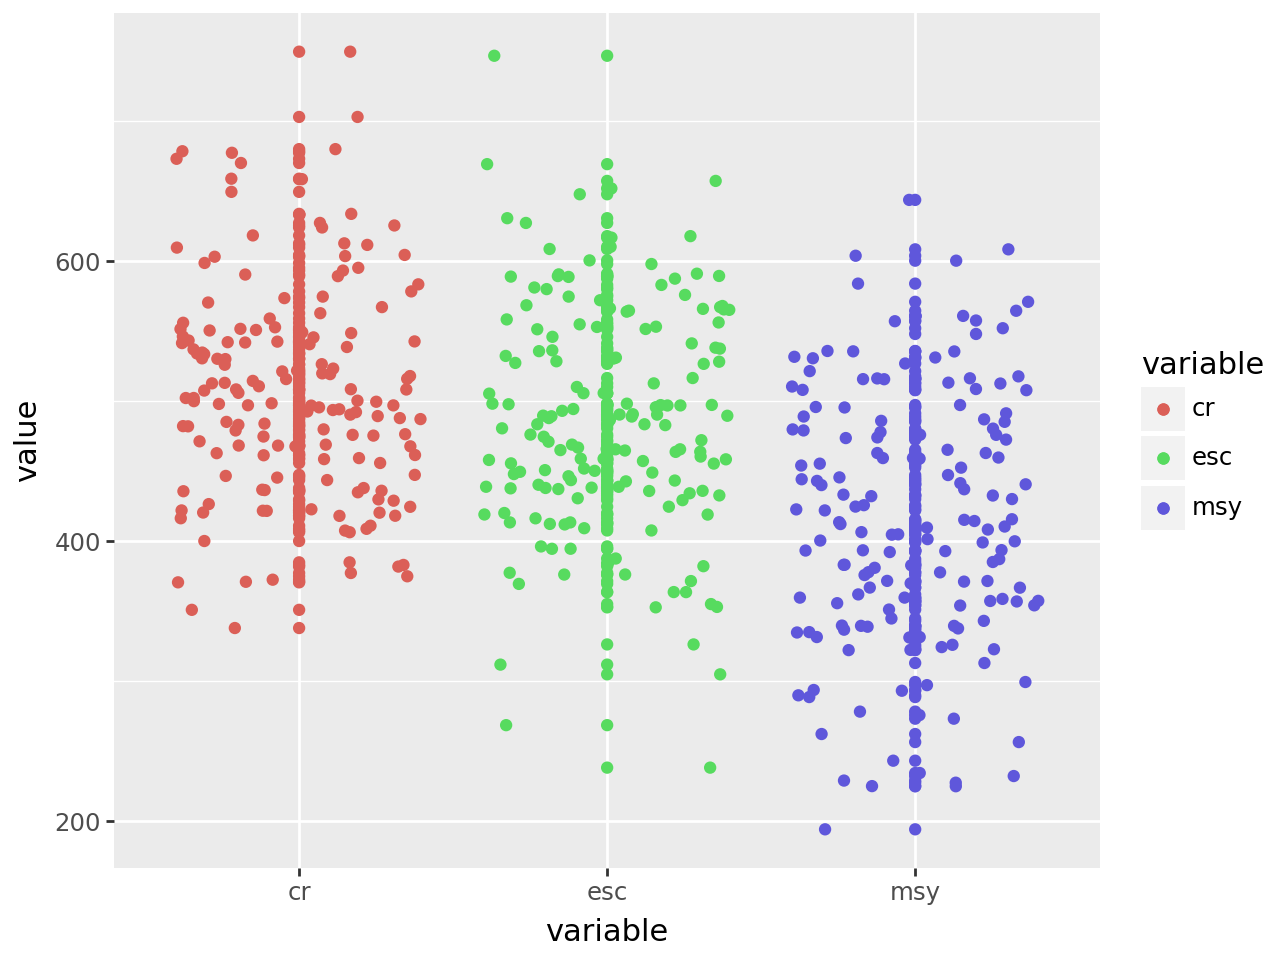

In [109]:
from plotnine import ggplot, aes, geom_point, geom_jitter

df = pd.DataFrame({
    'msy': msy_rews,
    'esc': esc_rews,
    'cr': cr_rews,
}).melt()

ggplot(df, aes(x='variable', y='value', color='variable')) + geom_point() + geom_jitter()